# Workshop 5: Airline Passenger Predictions with RNN (Felix code in PyTorch)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-05-19 16:53:48--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-05-19 16:53:49 (19.7 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



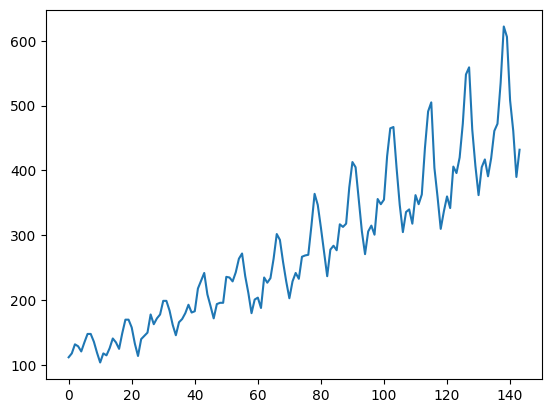

In [3]:
# Load and plot the dataset
dataset_raw = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python').values
plt.plot(dataset_raw)
plt.show()

In [4]:
# Create dataset function
def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
# Preprocess the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_raw.astype('float32'))
dataset.min(), dataset.max()

(0.0, 1.0)

In [6]:
# Split the dataset into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
train.shape, test.shape

((96, 1), (48, 1))

In [7]:
# Create input and output sequences for training and testing
look_back_memory = 1
variables = 1
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
trainX.shape, trainY.shape, testX.shape, testY.shape

((94, 1), (94,), (46, 1), (46,))

In [8]:
# Reshape the input sequences for PyTorch
trainX = torch.from_numpy(trainX).unsqueeze(2).float()
trainY = torch.from_numpy(trainY).unsqueeze(1).float()
testX = torch.from_numpy(testX).unsqueeze(2).float()
testY = torch.from_numpy(testY).unsqueeze(1).float()
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([94, 1, 1]),
 torch.Size([94, 1]),
 torch.Size([46, 1, 1]),
 torch.Size([46, 1]))

In [9]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
# Set random seed for reproducibility
torch.manual_seed(1234)

In [11]:
# Create and train the model
model = SimpleRNN(variables, 10, variables)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
losses_train = []
losses_test = []
for epoch in range(100):
    optimizer.zero_grad()
    output = model(trainX)
    loss = criterion(output, trainY)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      output = model(testX)
      loss_test = criterion(output, testY)
    losses_train.append(loss.detach().numpy())
    losses_test.append(loss_test.detach().numpy())
    print("Loss train: " + str(losses_train[-1]) + " Loss test: " + str(losses_test[-1]))

Loss train: 0.22112678 Loss test: 0.6490105
Loss train: 0.16858691 Loss test: 0.54648954
Loss train: 0.12426161 Loss test: 0.45436063
Loss train: 0.088050246 Loss test: 0.37252936
Loss train: 0.059731666 Loss test: 0.30097207
Loss train: 0.039032422 Loss test: 0.23970848
Loss train: 0.02553503 Loss test: 0.18867078
Loss train: 0.018562725 Loss test: 0.1476034
Loss train: 0.017089007 Loss test: 0.11597029
Loss train: 0.019691449 Loss test: 0.092880294
Loss train: 0.02462345 Loss test: 0.077100985
Loss train: 0.03007607 Loss test: 0.067235425
Loss train: 0.034557566 Loss test: 0.061994527
Loss train: 0.037167434 Loss test: 0.060387757
Loss train: 0.037633803 Loss test: 0.061757166
Loss train: 0.036172487 Loss test: 0.065703005
Loss train: 0.03328684 Loss test: 0.071972355
Loss train: 0.029589571 Loss test: 0.08035439
Loss train: 0.025675597 Loss test: 0.09060044
Loss train: 0.022043675 Loss test: 0.10237103
Loss train: 0.019054987 Loss test: 0.115209945
Loss train: 0.016917108 Loss test:

Text(0, 0.5, 'MSE')

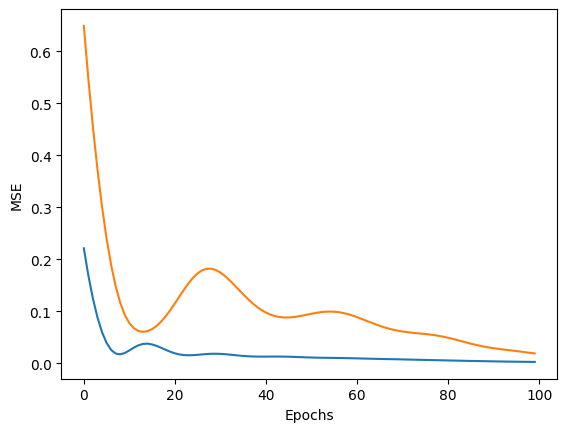

In [13]:
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [14]:
# Make predictions on the training and test sets
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

In [15]:
# Rescale the predictions back to the original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform(trainY.numpy())
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform(testY.numpy())

In [16]:
# Calculate root mean squared error (RMSE)
trainScore = math.sqrt(mean_squared_error(trainY_orig.flatten(), trainPredict.flatten()))
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig.flatten(), testPredict.flatten()))
print('Test Score: %.2f MSE' % (testScore))

Train Score: 25.47 MSE
Test Score: 70.90 MSE


In [17]:
# Create empty plots for visualization
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

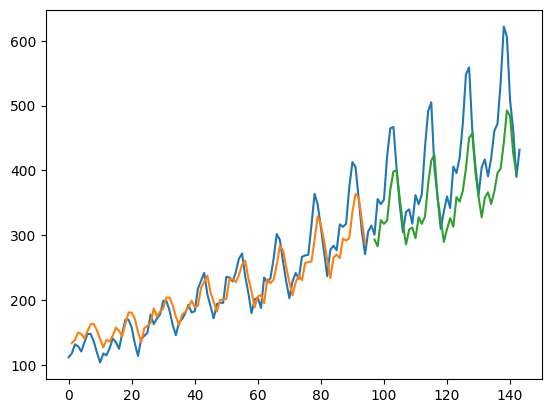

In [18]:
# Visualize the original data, training, and test predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [19]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [20]:
# Create and train the model
model = LSTMModel(variables, 10, variables)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [21]:
losses_train = []
losses_test = []
for epoch in range(100):
    optimizer.zero_grad()
    output = model(trainX)
    loss = criterion(output, trainY)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      output = model(testX)
      loss_test = criterion(output, testY)
    losses_train.append(loss.detach().numpy())
    losses_test.append(loss_test.detach().numpy())
    print("Loss train: " + str(losses_train[-1]) + " Loss test: " + str(losses_test[-1]))

Loss train: 0.064021185 Loss test: 0.36462298
Loss train: 0.054706473 Loss test: 0.3366969
Loss train: 0.046453487 Loss test: 0.30981544
Loss train: 0.0392295 Loss test: 0.2838935
Loss train: 0.033034805 Loss test: 0.25890532
Loss train: 0.027885234 Loss test: 0.23490736
Loss train: 0.02381052 Loss test: 0.2120462
Loss train: 0.020840427 Loss test: 0.19056816
Loss train: 0.018984267 Loss test: 0.17084044
Loss train: 0.018199962 Loss test: 0.1533705
Loss train: 0.01834788 Loss test: 0.13875757
Loss train: 0.019145174 Loss test: 0.12746467
Loss train: 0.02018867 Loss test: 0.11956485
Loss train: 0.021089066 Loss test: 0.114777535
Loss train: 0.021599343 Loss test: 0.11266599
Loss train: 0.021641236 Loss test: 0.11277334
Loss train: 0.02126378 Loss test: 0.11467494
Loss train: 0.020586113 Loss test: 0.117985494
Loss train: 0.01974935 Loss test: 0.12235099
Loss train: 0.018884048 Loss test: 0.12744026
Loss train: 0.018091904 Loss test: 0.13294114
Loss train: 0.017438537 Loss test: 0.138562

Text(0, 0.5, 'MSE')

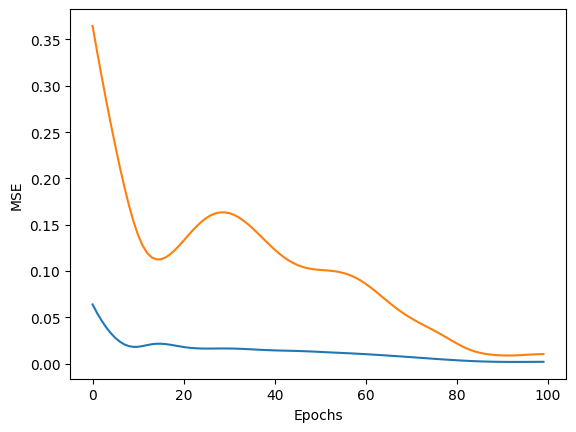

In [22]:
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [23]:
# Make predictions on the training and test sets
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

In [24]:
# Rescale the predictions back to the original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform(trainY.numpy())
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform(testY.numpy())

In [25]:
# Calculate root mean squared error (RMSE)
trainScore = math.sqrt(mean_squared_error(trainY_orig.flatten(), trainPredict.flatten()))
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig.flatten(), testPredict.flatten()))
print('Test Score: %.2f MSE' % (testScore))

Train Score: 23.99 MSE
Test Score: 53.03 MSE


In [26]:
# Create empty plots for visualization
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

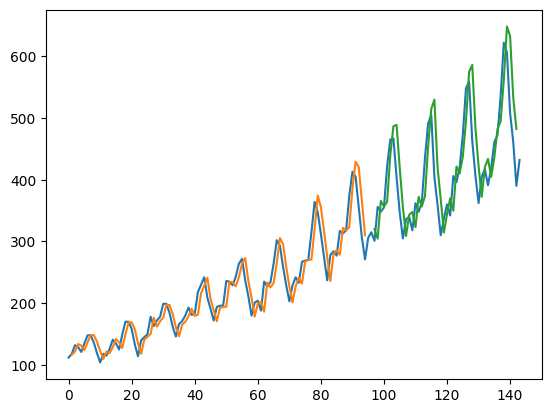

In [27]:
# Visualize the original data, training, and test predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [28]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [29]:
# Create and train the model
model = GRUModel(variables, 10, variables)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
losses_train = []
losses_test = []
for epoch in range(100):
    optimizer.zero_grad()
    output = model(trainX)
    loss = criterion(output, trainY)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      output = model(testX)
      loss_test = criterion(output, testY)
    losses_train.append(loss.detach().numpy())
    losses_test.append(loss_test.detach().numpy())
    print("Loss train: " + str(losses_train[-1]) + " Loss test: " + str(losses_test[-1]))

Loss train: 0.017183866 Loss test: 0.13861018
Loss train: 0.016835835 Loss test: 0.13628532
Loss train: 0.016084634 Loss test: 0.13900766
Loss train: 0.01526463 Loss test: 0.14117156
Loss train: 0.014709551 Loss test: 0.1383267
Loss train: 0.014186055 Loss test: 0.13010277
Loss train: 0.013493269 Loss test: 0.119066484
Loss train: 0.012778995 Loss test: 0.10804871
Loss train: 0.012181854 Loss test: 0.09945335
Loss train: 0.011621168 Loss test: 0.093985714
Loss train: 0.010963078 Loss test: 0.09077078
Loss train: 0.01024309 Loss test: 0.088316545
Loss train: 0.009574014 Loss test: 0.084757335
Loss train: 0.008969809 Loss test: 0.07867617
Loss train: 0.008329047 Loss test: 0.07033594
Loss train: 0.007636319 Loss test: 0.061253298
Loss train: 0.006989921 Loss test: 0.053259145
Loss train: 0.006412913 Loss test: 0.047407154
Loss train: 0.005815097 Loss test: 0.043363873
Loss train: 0.0051939837 Loss test: 0.03998953
Loss train: 0.0046418393 Loss test: 0.03586159
Loss train: 0.0041589253 Lo

Text(0, 0.5, 'MSE')

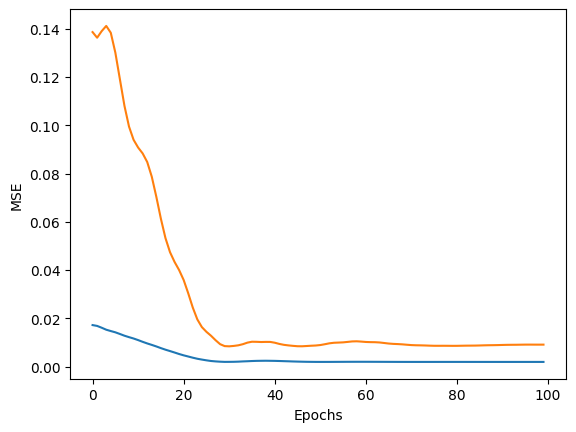

In [31]:
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [32]:
# Make predictions on the training and test sets
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

In [33]:
# Rescale the predictions back to the original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform(trainY.numpy())
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform(testY.numpy())

In [34]:
# Calculate root mean squared error (RMSE)
trainScore = math.sqrt(mean_squared_error(trainY_orig.flatten(), trainPredict.flatten()))
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig.flatten(), testPredict.flatten()))
print('Test Score: %.2f MSE' % (testScore))

Train Score: 22.67 MSE
Test Score: 49.37 MSE


In [35]:
# Create empty plots for visualization
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

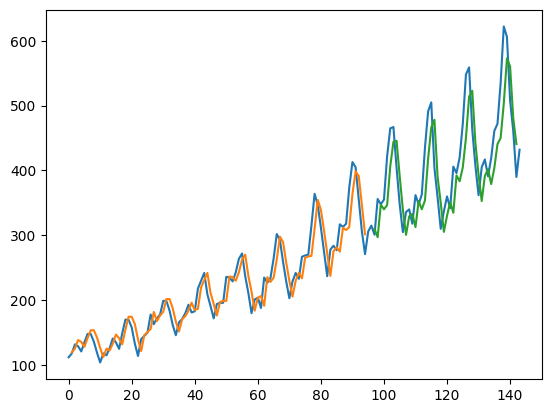

In [36]:
# Visualize the original data, training, and test predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()